In [50]:
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cosine

import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Load Data

In [51]:
# Load CowLSTM embeddings
model_dir = Path('cowlstm_embeddings_dim16')

embeddings = np.load(model_dir / 'embeddings.npy')
with open(model_dir / 'embedding_metadata.json', 'r') as f:
    metadata = json.load(f)

cow_ids = metadata['cow_ids']

print(f"Loaded embeddings for {len(cow_ids)} cows")
print(f"Embedding dimension: {metadata['embedding_dim']}")
print(f"Best validation accuracy: {metadata['best_val_acc']:.4f}")
print(f"\nEmbeddings shape: {embeddings.shape}")
print(f"\nFirst 10 cow IDs: {cow_ids[:10]}")

Loaded embeddings for 43 cows
Embedding dimension: 16
Best validation accuracy: 0.7363

Embeddings shape: (43, 16)

First 10 cow IDs: ['365d', '365e', '3660', '3663', '3664', '3665', '3666', '3667', '3669', '366a']


In [52]:
# Load per-cow accuracy
accuracy_df = pd.read_csv(model_dir / 'per_cow_accuracy.csv')
print(f"\nPer-cow accuracy statistics:")
print(accuracy_df['accuracy'].describe())
accuracy_df.head()


Per-cow accuracy statistics:
count    43.000000
mean      0.718922
std       0.066180
min       0.508197
25%       0.677619
50%       0.731518
75%       0.761020
max       0.849112
Name: accuracy, dtype: float64


,cow_id,accuracy,correct,total
0,3d05,0.849112,287,338
1,366d,0.839779,152,181
2,3cee,0.807263,289,358
3,3cfb,0.802632,183,228
4,3cf8,0.789593,349,442


In [53]:
# Load temporal graphs to compute network statistics
with open('network_sequence/network_sequence_rssi-68_20251209_125949.pkl', 'rb') as f:
    temporal_graphs = pickle.load(f)

print(f"Loaded {len(temporal_graphs)} temporal snapshots")
print(f"Timespan: {temporal_graphs[0]['timestamp']} to {temporal_graphs[-1]['timestamp']}")

Loaded 18720 temporal snapshots
Timespan: 2025-03-17 12:00:00 to 2025-03-23 23:59:30


In [54]:
# Check structure of temporal graphs
print("Temporal graph structure:")
print(f"Type: {type(temporal_graphs[0])}")
print(f"Keys: {temporal_graphs[0].keys() if hasattr(temporal_graphs[0], 'keys') else 'Not a dict'}")
print(f"\nFirst snapshot sample:")
print(temporal_graphs[0])

Temporal graph structure:
Type: <class 'dict'>
Keys: dict_keys(['timestamp', 'graph', 'num_nodes', 'num_edges', 'num_measurements'])

First snapshot sample:
{'timestamp': Timestamp('2025-03-17 12:00:00'), 'graph': <networkx.classes.graph.Graph object at 0x7ff51948adc0>, 'num_nodes': 49, 'num_edges': 18, 'num_measurements': 472}


## 2. Embedding Statistics & Basic Visualization

Embedding Statistics:
  Mean: 0.0005
  Std: 0.1865
  Min: -0.4902
  Max: 0.4609
  L2 norm (mean): 0.7448


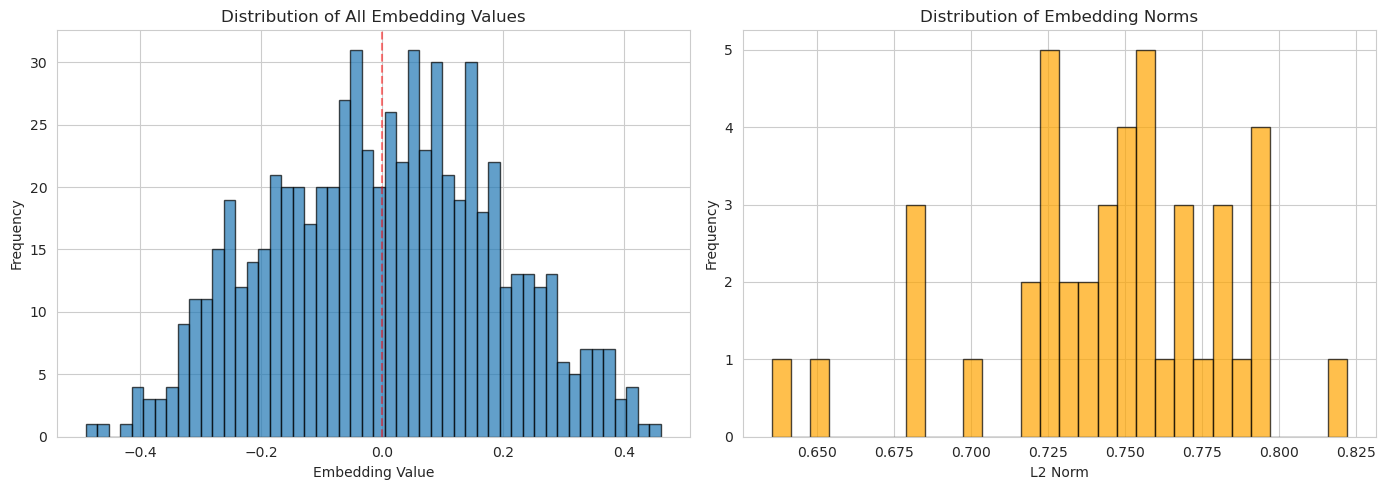

In [55]:
# Basic embedding statistics
print("Embedding Statistics:")
print(f"  Mean: {embeddings.mean():.4f}")
print(f"  Std: {embeddings.std():.4f}")
print(f"  Min: {embeddings.min():.4f}")
print(f"  Max: {embeddings.max():.4f}")
print(f"  L2 norm (mean): {np.linalg.norm(embeddings, axis=1).mean():.4f}")

# Distribution of embedding values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(embeddings.flatten(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Embedding Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of All Embedding Values')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5)

norms = np.linalg.norm(embeddings, axis=1)
axes[1].hist(norms, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('L2 Norm')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Embedding Norms')

plt.tight_layout()
plt.show()

Pairwise Similarity Statistics:
  Mean: -0.0178
  Std: 0.2028
  Min: -0.7207
  Max: 0.3989


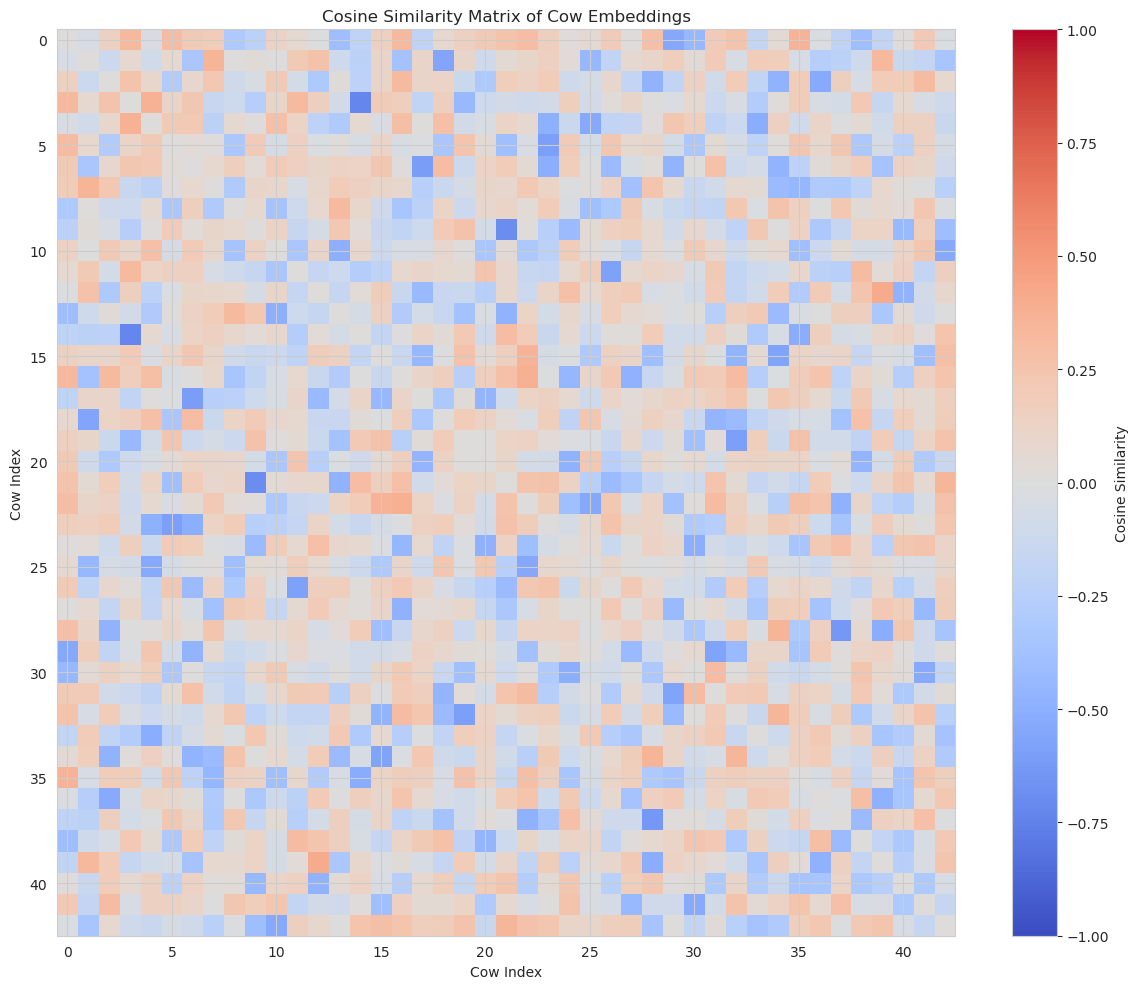

In [56]:
# Compute pairwise cosine similarities
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings)
np.fill_diagonal(similarity_matrix, 0)  # Remove self-similarity

print(f"Pairwise Similarity Statistics:")
print(f"  Mean: {similarity_matrix.mean():.4f}")
print(f"  Std: {similarity_matrix.std():.4f}")
print(f"  Min: {similarity_matrix.min():.4f}")
print(f"  Max: {similarity_matrix.max():.4f}")

# Plot similarity matrix
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(similarity_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax.set_xlabel('Cow Index')
ax.set_ylabel('Cow Index')
ax.set_title('Cosine Similarity Matrix of Cow Embeddings')
plt.colorbar(im, ax=ax, label='Cosine Similarity')
plt.tight_layout()
plt.show()

## 3. Dimensionality Reduction & Visualization

PCA Explained Variance Ratio:
  PC1: 0.0804
  PC2: 0.0776
  Total: 0.1580

Computing t-SNE (perplexity=10)...


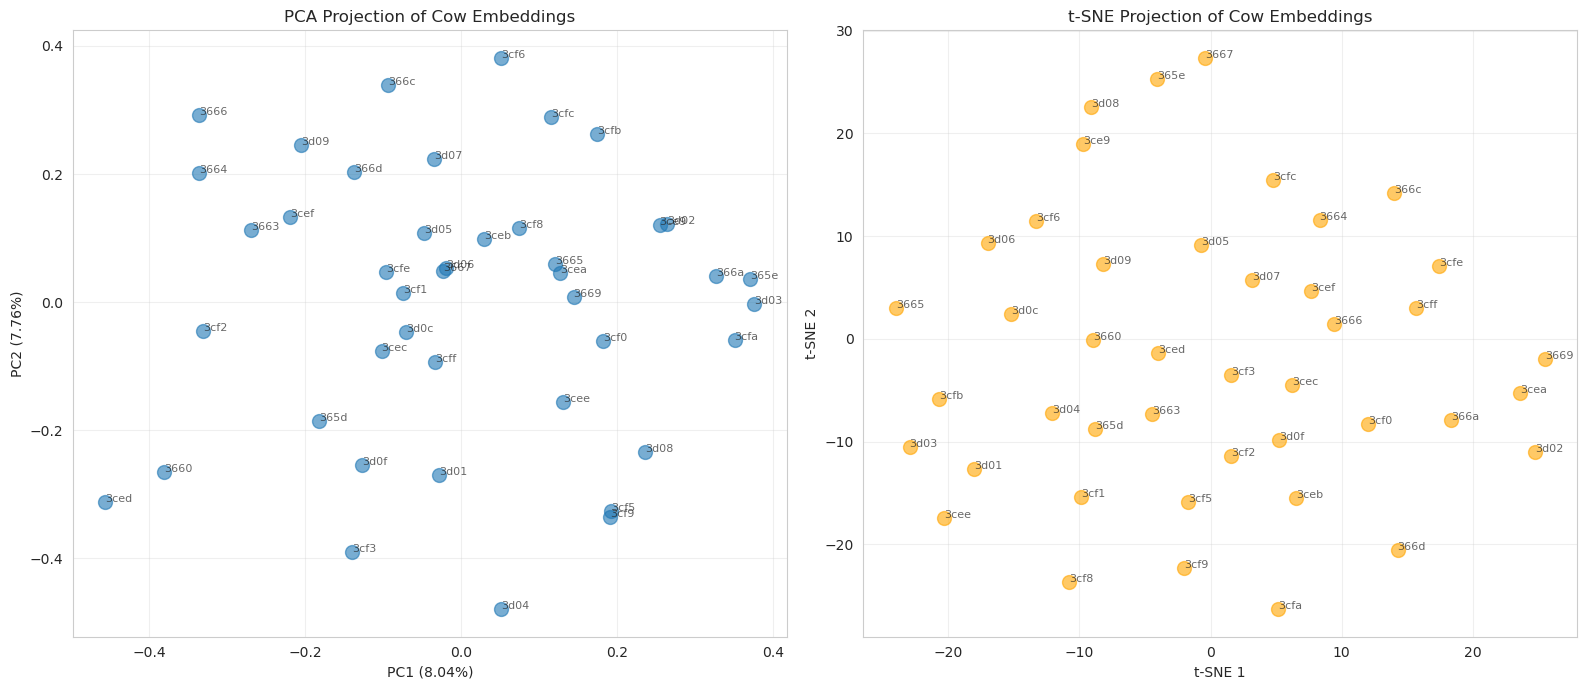

In [57]:
# PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

print(f"PCA Explained Variance Ratio:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"  Total: {pca.explained_variance_ratio_.sum():.4f}")

# t-SNE
print("\nComputing t-SNE (perplexity=10)...")
tsne = TSNE(n_components=2, perplexity=10, random_state=42, n_iter=1000)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA plot
axes[0].scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.6, s=100)
for i, cow_id in enumerate(cow_ids):
    axes[0].annotate(cow_id, (embeddings_pca[i, 0], embeddings_pca[i, 1]), 
                     fontsize=8, alpha=0.7)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0].set_title('PCA Projection of Cow Embeddings')
axes[0].grid(True, alpha=0.3)

# t-SNE plot
axes[1].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.6, s=100, color='orange')
for i, cow_id in enumerate(cow_ids):
    axes[1].annotate(cow_id, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), 
                     fontsize=8, alpha=0.7)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('t-SNE Projection of Cow Embeddings')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### t-SNE Quality Assessment

t-SNE is a **visualization tool**, and its quality should be evaluated separately from clustering. Key concerns:
- Does it preserve local neighborhoods from the original space?
- Is it stable across different hyperparameters?
- Does it create artificial structure?

In [58]:
# Assess t-SNE quality using trustworthiness and continuity
from sklearn.manifold import trustworthiness
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

# 1. Trustworthiness: measures if points close in t-SNE are close in original space
# Range: 0-1, higher is better. > 0.9 is excellent, > 0.8 is good
trust_scores = {}
for n_neighbors in [5, 10, 20]:
    trust = trustworthiness(embeddings, embeddings_tsne, n_neighbors=n_neighbors)
    trust_scores[n_neighbors] = trust

print("t-SNE Quality Assessment:")
print("="*60)
print("\n1. Trustworthiness (are close points in t-SNE truly close?):")
for k, score in trust_scores.items():
    quality = "Excellent" if score > 0.9 else "Good" if score > 0.8 else "Fair" if score > 0.7 else "Poor"
    print(f"   k={k:2d} neighbors: {score:.4f} ({quality})")

# 2. k-NN preservation: percentage of k-nearest neighbors preserved
def knn_preservation(X_original, X_embedded, k=10):
    """Calculate what % of k-nearest neighbors are preserved"""
    nbrs_original = NearestNeighbors(n_neighbors=k+1).fit(X_original)
    nbrs_embedded = NearestNeighbors(n_neighbors=k+1).fit(X_embedded)
    
    _, indices_original = nbrs_original.kneighbors(X_original)
    _, indices_embedded = nbrs_embedded.kneighbors(X_embedded)
    
    # Exclude self (first neighbor)
    indices_original = indices_original[:, 1:]
    indices_embedded = indices_embedded[:, 1:]
    
    # Calculate preservation
    preserved = []
    for i in range(len(X_original)):
        orig_neighbors = set(indices_original[i])
        embd_neighbors = set(indices_embedded[i])
        preserved.append(len(orig_neighbors & embd_neighbors) / k)
    
    return np.mean(preserved)

print("\n2. k-Nearest Neighbor Preservation:")
for k in [5, 10, 20]:
    preservation = knn_preservation(embeddings, embeddings_tsne, k=k)
    quality = "Excellent" if preservation > 0.7 else "Good" if preservation > 0.5 else "Fair" if preservation > 0.3 else "Poor"
    print(f"   k={k:2d} neighbors: {preservation*100:.1f}% preserved ({quality})")

# 3. Global structure: correlation between pairwise distances
print("\n3. Global Distance Preservation:")
# Sample pairs to avoid memory issues
n_samples = min(1000, len(embeddings) * (len(embeddings) - 1) // 2)
np.random.seed(42)
idx_pairs = np.random.choice(len(embeddings), size=(n_samples, 2), replace=True)

dist_original = [np.linalg.norm(embeddings[i] - embeddings[j]) 
                 for i, j in idx_pairs if i != j]
dist_tsne = [np.linalg.norm(embeddings_tsne[i] - embeddings_tsne[j]) 
             for i, j in idx_pairs if i != j]

corr_dist = np.corrcoef(dist_original, dist_tsne)[0, 1]
quality = "Good" if corr_dist > 0.7 else "Fair" if corr_dist > 0.5 else "Poor"
print(f"   Distance correlation: {corr_dist:.4f} ({quality})")
print(f"   Note: t-SNE focuses on local structure, low global correlation is normal")

print("\n" + "="*60)
print("💡 Interpretation:")
print("   - Trustworthiness > 0.8: t-SNE reliably shows local structure")
print("   - k-NN preservation > 50%: neighborhoods reasonably preserved")
print("   - Low global correlation is expected for t-SNE (it's local-focused)")
print("="*60)

t-SNE Quality Assessment:

1. Trustworthiness (are close points in t-SNE truly close?):
   k= 5 neighbors: 0.7451 (Fair)
   k=10 neighbors: 0.6648 (Poor)
   k=20 neighbors: 0.5910 (Poor)

2. k-Nearest Neighbor Preservation:
   k= 5 neighbors: 45.1% preserved (Fair)
   k=10 neighbors: 44.2% preserved (Fair)
   k=20 neighbors: 56.0% preserved (Good)

3. Global Distance Preservation:
   Distance correlation: 0.2650 (Poor)
   Note: t-SNE focuses on local structure, low global correlation is normal

💡 Interpretation:
   - Trustworthiness > 0.8: t-SNE reliably shows local structure
   - k-NN preservation > 50%: neighborhoods reasonably preserved
   - Low global correlation is expected for t-SNE (it's local-focused)


Testing t-SNE with different perplexity values...
(This may take a minute...)



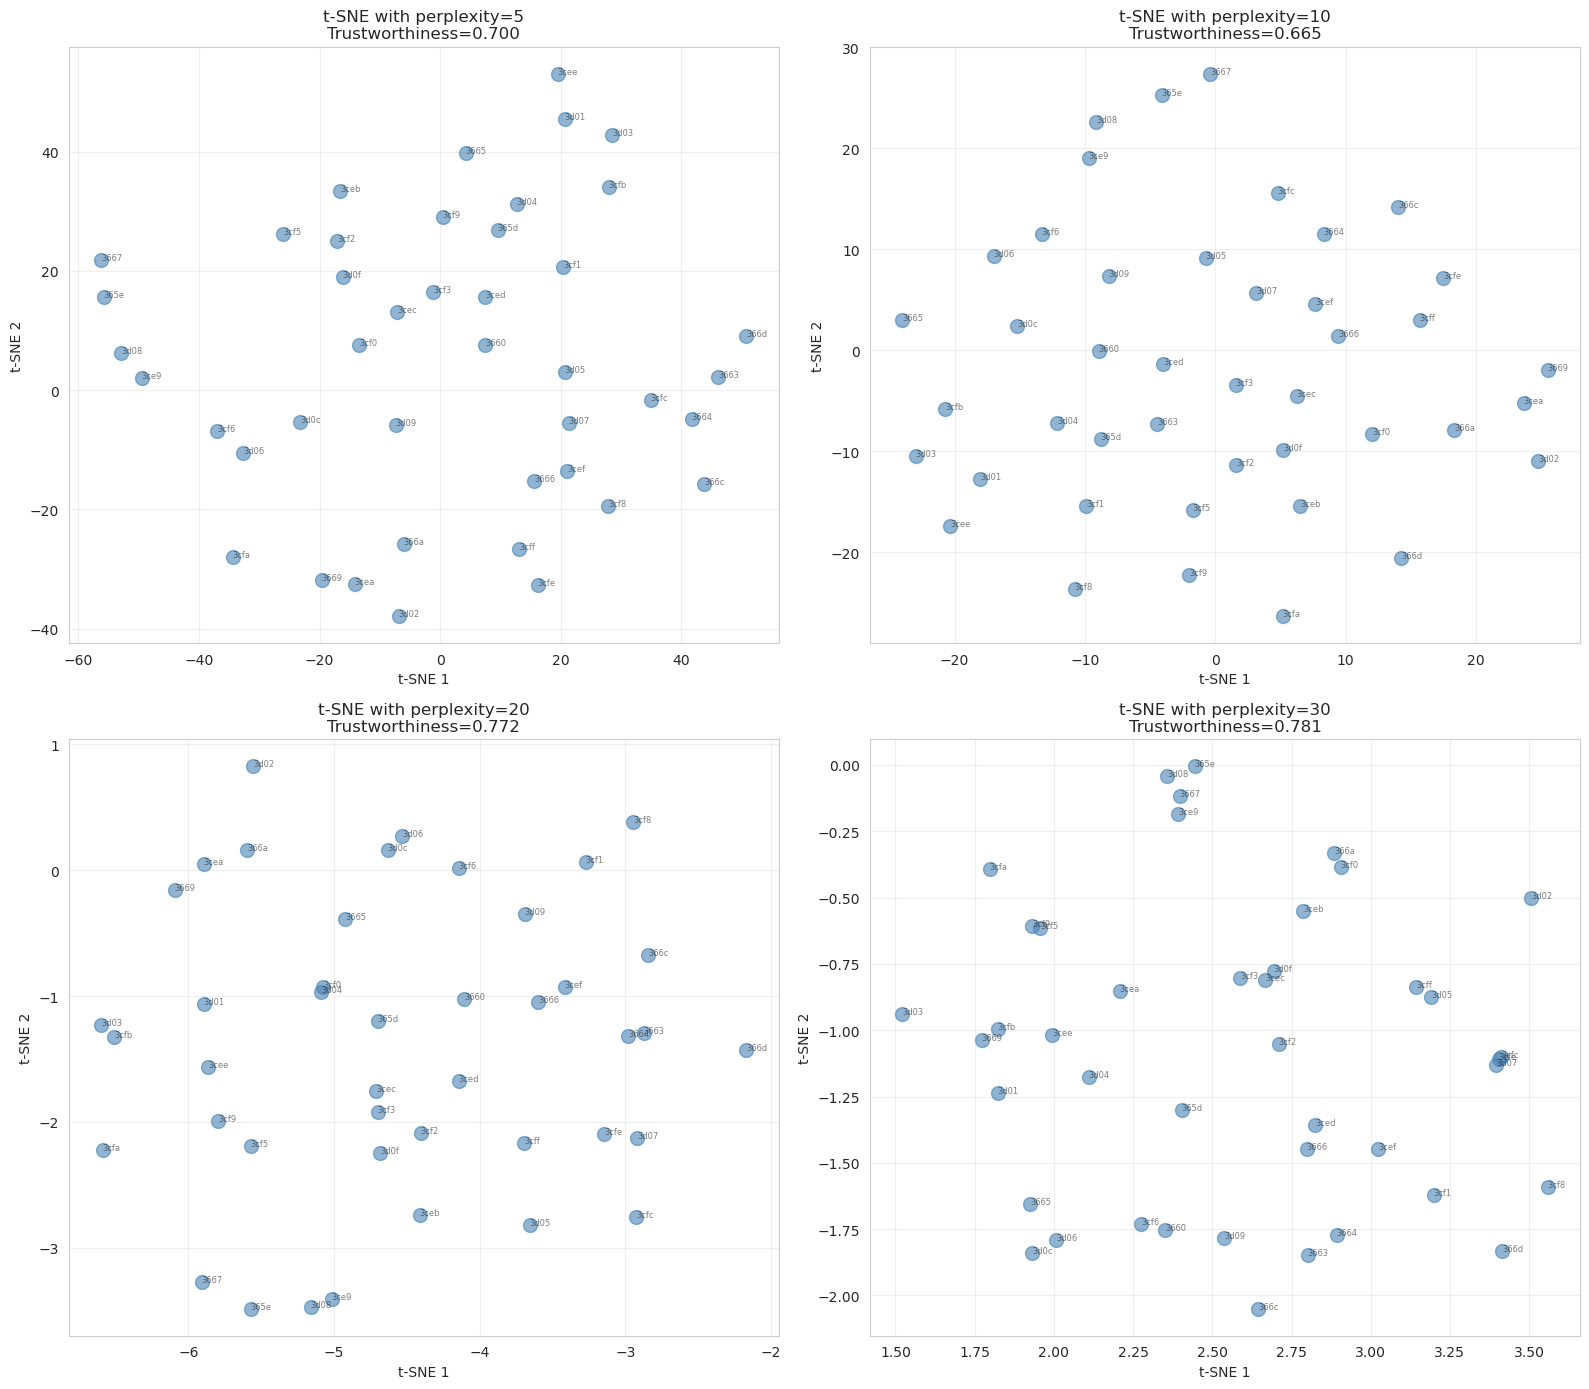


Perplexity Comparison:
Perplexity   Trustworthiness    Quality
--------------------------------------------------
5            0.7000             Poor
10           0.6648             Poor
20           0.7718             Fair
30           0.7813             Fair

💡 If visualizations are very different across perplexities,
   the data may not have strong natural structure.


In [59]:
# Test different perplexity values to assess stability
print("Testing t-SNE with different perplexity values...")
print("(This may take a minute...)\n")

perplexities = [5, 10, 20, 30]
tsne_results = {}
trust_by_perp = {}

for perp in perplexities:
    tsne_temp = TSNE(n_components=2, perplexity=perp, random_state=42, n_iter=1000)
    emb_temp = tsne_temp.fit_transform(embeddings)
    tsne_results[perp] = emb_temp
    
    # Compute trustworthiness
    trust = trustworthiness(embeddings, emb_temp, n_neighbors=10)
    trust_by_perp[perp] = trust

# Visualize different perplexities
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, perp in enumerate(perplexities):
    ax = axes[idx]
    emb_temp = tsne_results[perp]
    
    scatter = ax.scatter(emb_temp[:, 0], emb_temp[:, 1], 
                         alpha=0.6, s=100, color='steelblue')
    
    for i, cow_id in enumerate(cow_ids):
        ax.annotate(cow_id, (emb_temp[i, 0], emb_temp[i, 1]), 
                   fontsize=6, alpha=0.6)
    
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_title(f't-SNE with perplexity={perp}\nTrustworthiness={trust_by_perp[perp]:.3f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPerplexity Comparison:")
print(f"{'Perplexity':<12} {'Trustworthiness':<18} {'Quality'}")
print("-" * 50)
for perp in perplexities:
    trust = trust_by_perp[perp]
    quality = "Excellent" if trust > 0.9 else "Good" if trust > 0.8 else "Fair" if trust > 0.7 else "Poor"
    print(f"{perp:<12} {trust:<18.4f} {quality}")

print("\n💡 If visualizations are very different across perplexities,")
print("   the data may not have strong natural structure.")

Variance explained by each principal component:
  PC1: 0.0804 (8.04%)
  PC2: 0.0776 (7.76%)
  PC3: 0.0734 (7.34%)
  PC4: 0.0704 (7.04%)
  PC5: 0.0687 (6.87%)
  PC6: 0.0680 (6.80%)
  PC7: 0.0655 (6.55%)
  PC8: 0.0646 (6.46%)
  PC9: 0.0637 (6.37%)
  PC10: 0.0603 (6.03%)

Cumulative variance explained:
  First 2 PCs: 0.1580 (15.80%)
  First 3 PCs: 0.2314 (23.14%)
  First 4 PCs: 0.3018 (30.18%)
  First 5 PCs: 0.3705 (37.05%)
  First 8 PCs: 0.5686 (56.86%)
  First 10 PCs: 0.6927 (69.27%)
  First 16 PCs: 1.0000 (100.00%)


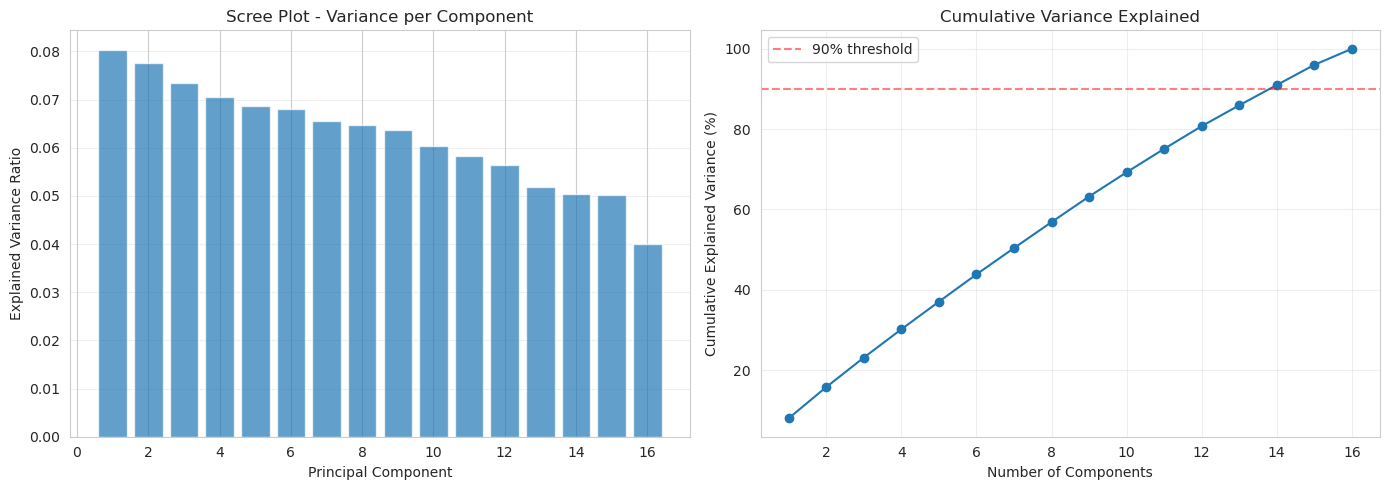

In [60]:
# Full PCA to understand variance distribution
pca_full = PCA()
pca_full.fit(embeddings)

print("Variance explained by each principal component:")
for i, var in enumerate(pca_full.explained_variance_ratio_[:10]):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

print(f"\nCumulative variance explained:")
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
for n_comp in [2, 3, 4, 5, 8, 10, 16]:
    if n_comp <= len(cumsum):
        print(f"  First {n_comp} PCs: {cumsum[n_comp-1]:.4f} ({cumsum[n_comp-1]*100:.2f}%)")

# Scree plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
            pca_full.explained_variance_ratio_, alpha=0.7)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot - Variance per Component')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].plot(range(1, len(cumsum)+1), cumsum*100, marker='o')
axes[1].axhline(90, color='red', linestyle='--', alpha=0.5, label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance (%)')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Clustering Analysis

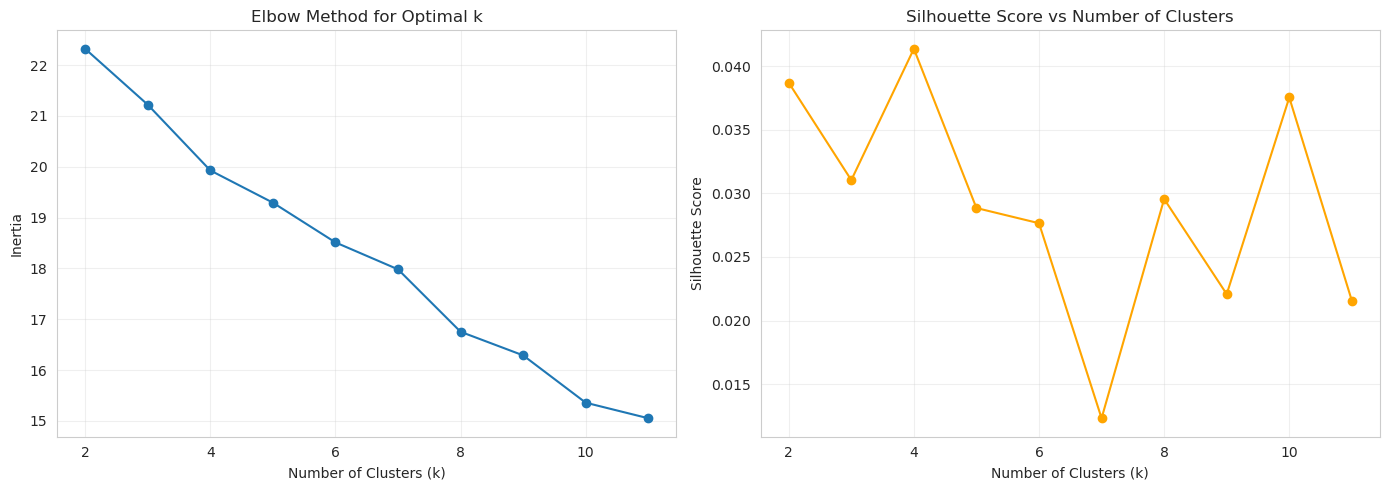


Optimal number of clusters (max silhouette): 4
Max silhouette score: 0.0414


In [61]:
# Determine optimal number of clusters using elbow method and silhouette score
inertias = []
silhouette_scores = []
k_range = range(2, 12)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, marker='o')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, marker='o', color='orange')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters (max silhouette): {optimal_k}")
print(f"Max silhouette score: {max(silhouette_scores):.4f}")

Clustering with k=4:
  Silhouette Score: 0.0414
  Davies-Bouldin Index: 2.9041

Cluster sizes:
  Cluster 0: 8 cows
  Cluster 1: 9 cows
  Cluster 2: 12 cows
  Cluster 3: 14 cows


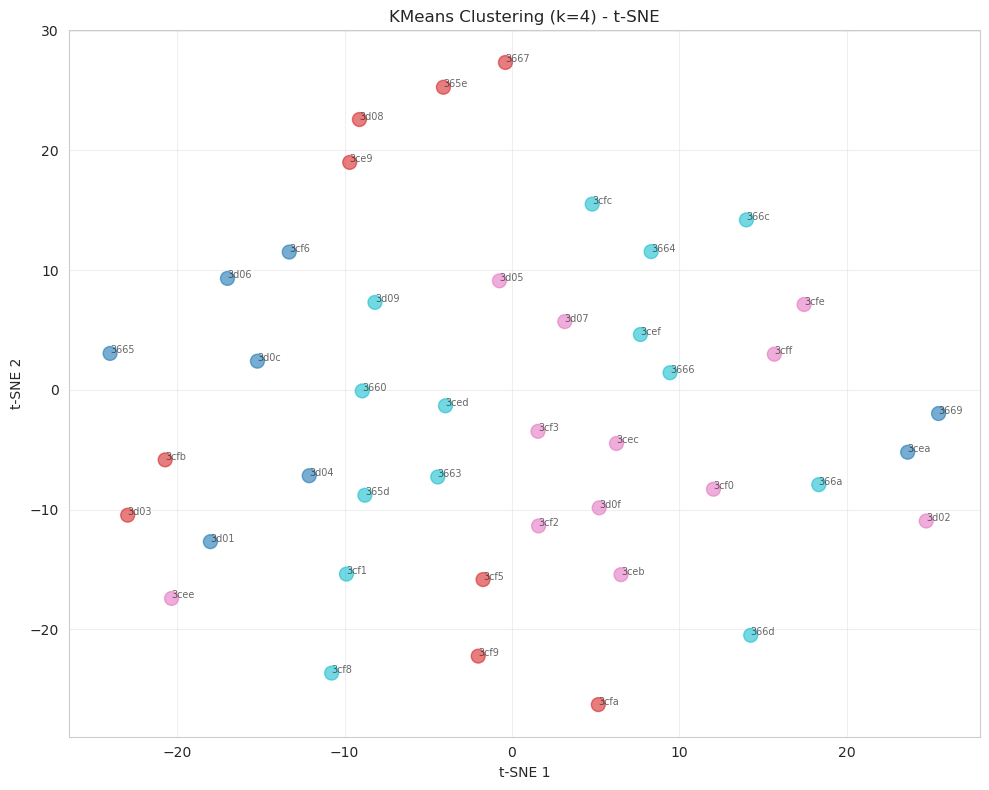

In [62]:
# Apply KMeans with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

print(f"Clustering with k={optimal_k}:")
print(f"  Silhouette Score: {silhouette_score(embeddings, cluster_labels):.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_score(embeddings, cluster_labels):.4f}")

# Cluster sizes
unique, counts = np.unique(cluster_labels, return_counts=True)
print(f"\nCluster sizes:")
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} cows")

# Visualize clusters
plt.figure(figsize=(10, 8))

# t-SNE with clusters
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                      c=cluster_labels, cmap='tab10', alpha=0.6, s=100)
for i, cow_id in enumerate(cow_ids):
    plt.annotate(cow_id, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), 
                 fontsize=7, alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f'KMeans Clustering (k={optimal_k}) - t-SNE')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### ⚠️ Clustering Quality Assessment

The clustering metrics indicate **poor cluster quality**:
- **Silhouette Score = 0.0414** (very low, close to 0)
  - Good: > 0.5
  - Acceptable: 0.25-0.5  
  - Poor: < 0.25
  - **Interpretation**: Clusters are heavily overlapping in the embedding space
  
- **Davies-Bouldin Index = 2.9041** (high)
  - Good: < 1.0
  - Acceptable: 1.0-2.0
  - Poor: > 2.0
  - **Interpretation**: Clusters are not well-separated

**Important**: The t-SNE visualization shows apparent separation, but this is **misleading**. t-SNE is a non-linear dimensionality reduction that can create artificial visual separation. The clustering is performed in the original 16-dimensional embedding space where clusters overlap significantly.

This suggests the cow embeddings do not naturally form distinct groups - the behavior patterns may exist on a continuum rather than discrete categories.

In [63]:
# Compare clustering metrics in original vs t-SNE space
from sklearn.metrics.pairwise import euclidean_distances

# Compute cluster compactness and separation
within_cluster_dists = []
between_cluster_dists = []

for i in range(optimal_k):
    cluster_points = embeddings[cluster_labels == i]
    # Within-cluster distances (compactness)
    if len(cluster_points) > 1:
        within_dist = euclidean_distances(cluster_points).mean()
        within_cluster_dists.append(within_dist)
    
    # Between-cluster distances (separation)
    for j in range(i+1, optimal_k):
        other_points = embeddings[cluster_labels == j]
        if len(other_points) > 0:
            between_dist = euclidean_distances(cluster_points, other_points).mean()
            between_cluster_dists.append(between_dist)

print("Cluster Analysis in Original 16D Embedding Space:")
print(f"  Mean within-cluster distance: {np.mean(within_cluster_dists):.4f}")
print(f"  Mean between-cluster distance: {np.mean(between_cluster_dists):.4f}")
print(f"  Separation ratio (between/within): {np.mean(between_cluster_dists)/np.mean(within_cluster_dists):.2f}")
print(f"\n  💡 Good clustering: separation ratio > 2.0")
print(f"     Your ratio is {np.mean(between_cluster_dists)/np.mean(within_cluster_dists):.2f} - clusters overlap significantly")

# For comparison: silhouette score interpretation
print(f"\nSilhouette Score Interpretation:")
print(f"  Your score: {silhouette_score(embeddings, cluster_labels):.4f}")
print(f"  > 0.70: Strong structure")
print(f"  0.50-0.70: Reasonable structure")  
print(f"  0.25-0.50: Weak structure")
print(f"  < 0.25: No substantial structure (your case)")

Cluster Analysis in Original 16D Embedding Space:
  Mean within-cluster distance: 0.9067
  Mean between-cluster distance: 1.0774
  Separation ratio (between/within): 1.19

  💡 Good clustering: separation ratio > 2.0
     Your ratio is 1.19 - clusters overlap significantly

Silhouette Score Interpretation:
  Your score: 0.0414
  > 0.70: Strong structure
  0.50-0.70: Reasonable structure
  0.25-0.50: Weak structure
  < 0.25: No substantial structure (your case)


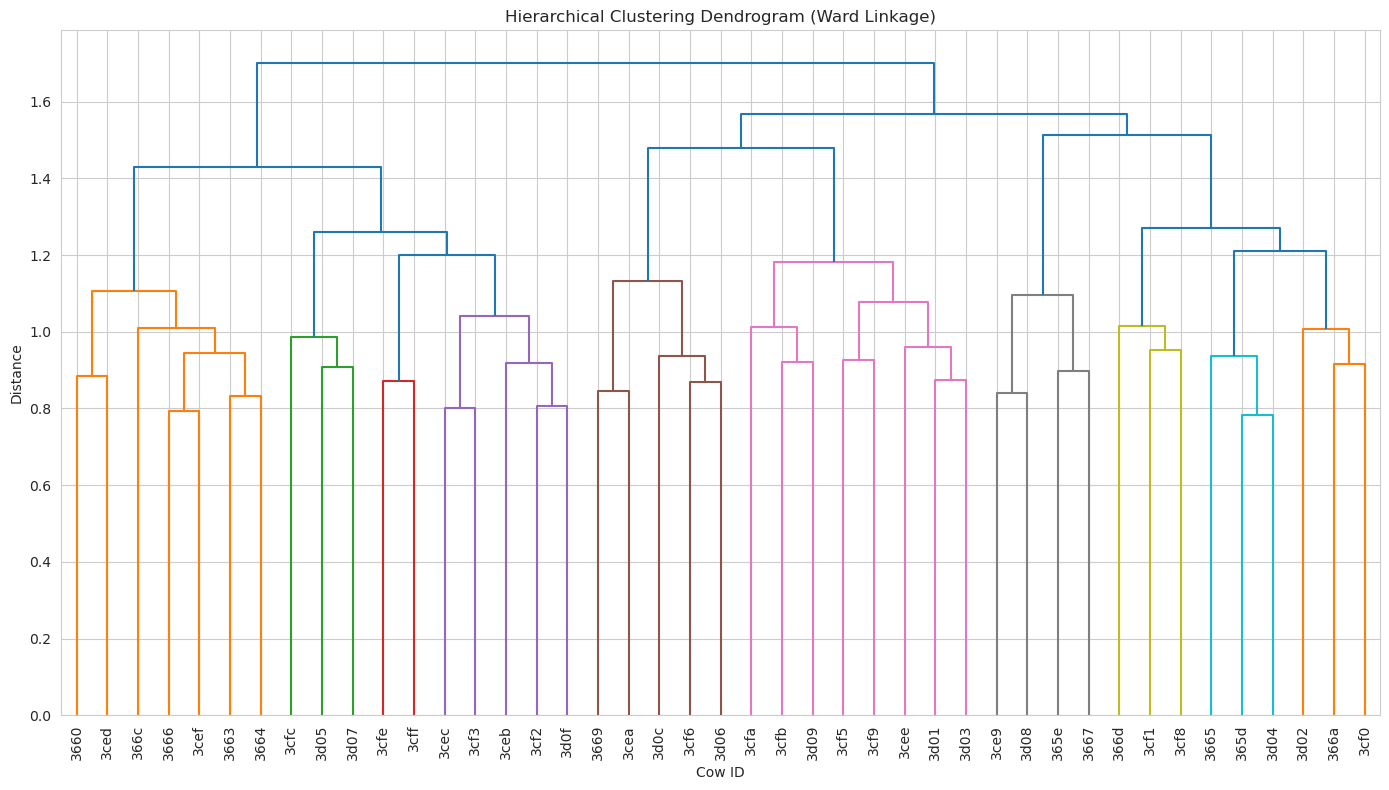

In [64]:
# Hierarchical clustering dendrogram
linkage_matrix = linkage(embeddings, method='ward')

plt.figure(figsize=(14, 8))
dendrogram(linkage_matrix, labels=cow_ids, leaf_font_size=10)
plt.xlabel('Cow ID')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 5. Per-Cow Accuracy Analysis

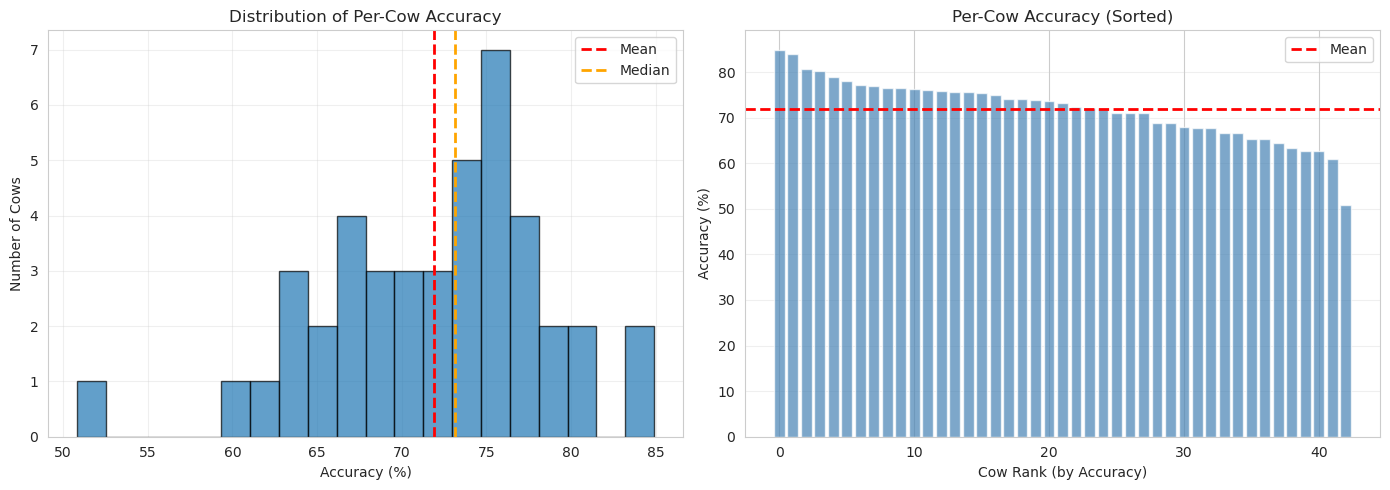


Top 5 performers:
cow_id  accuracy
  3d05  0.849112
  366d  0.839779
  3cee  0.807263
  3cfb  0.802632
  3cf8  0.789593

Bottom 5 performers:
cow_id  accuracy
  365e  0.633166
  365d  0.627660
  3ced  0.627119
  3d03  0.608333
  3cf3  0.508197


In [65]:
# Plot per-cow accuracy distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(accuracy_df['accuracy'] * 100, bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(accuracy_df['accuracy'].mean() * 100, color='red', 
                linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(accuracy_df['accuracy'].median() * 100, color='orange', 
                linestyle='--', linewidth=2, label='Median')
axes[0].set_xlabel('Accuracy (%)')
axes[0].set_ylabel('Number of Cows')
axes[0].set_title('Distribution of Per-Cow Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sorted bar plot
accuracy_df_sorted = accuracy_df.sort_values('accuracy', ascending=False)
axes[1].bar(range(len(accuracy_df_sorted)), accuracy_df_sorted['accuracy'] * 100, 
            color='steelblue', alpha=0.7)
axes[1].set_xlabel('Cow Rank (by Accuracy)')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Per-Cow Accuracy (Sorted)')
axes[1].axhline(accuracy_df['accuracy'].mean() * 100, color='red', 
                linestyle='--', linewidth=2, label='Mean')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Top and bottom performers
print("\nTop 5 performers:")
print(accuracy_df_sorted.head()[['cow_id', 'accuracy']].to_string(index=False))
print("\nBottom 5 performers:")
print(accuracy_df_sorted.tail()[['cow_id', 'accuracy']].to_string(index=False))

## 6. Network Topology Analysis

In [66]:
# Compute per-cow network statistics
# Statistics per cow across all snapshots
cow_degrees = defaultdict(list)
cow_appearances = defaultdict(int)
edge_counts = defaultdict(lambda: defaultdict(int))  # cow1 -> cow2 -> count

for snapshot in temporal_graphs:
    graph = snapshot['graph']  # NetworkX graph object
    
    # Build adjacency for this snapshot
    adj = defaultdict(set)
    for u, v in graph.edges():
        adj[u].add(v)
        adj[v].add(u)
        edge_counts[u][v] += 1
        edge_counts[v][u] += 1
    
    # Record degrees
    for cow in adj:
        cow_degrees[cow].append(len(adj[cow]))
        cow_appearances[cow] += 1

# Compute mean degree and appearance rate
network_stats = []
for cow_id in cow_ids:
    if cow_id in cow_degrees:
        mean_degree = np.mean(cow_degrees[cow_id])
        std_degree = np.std(cow_degrees[cow_id])
        appearance_rate = cow_appearances[cow_id] / len(temporal_graphs)
    else:
        mean_degree = 0
        std_degree = 0
        appearance_rate = 0
    
    network_stats.append({
        'cow_id': cow_id,
        'mean_degree': mean_degree,
        'std_degree': std_degree,
        'appearance_rate': appearance_rate
    })

network_df = pd.DataFrame(network_stats)
print("Network statistics:")
print(network_df.describe())
network_df.head()

Network statistics:
       mean_degree  std_degree  appearance_rate
count    43.000000   43.000000        43.000000
mean      1.436773    0.696152         0.483858
std       0.146414    0.126578         0.111042
min       1.202733    0.469955         0.273771
25%       1.338270    0.623948         0.390919
50%       1.442749    0.695542         0.508173
75%       1.515901    0.788864         0.555262
max       1.869964    1.044325         0.780929


,cow_id,mean_degree,std_degree,appearance_rate
0,365d,1.225896,0.488430,0.306944
1,365e,1.478270,0.735844,0.500267
2,3660,1.359525,0.618729,0.395673
3,3663,1.367783,0.629168,0.475534
4,3664,1.347418,0.632587,0.409615


In [67]:
# Merge with accuracy data
analysis_df = accuracy_df.merge(network_df, on='cow_id')
analysis_df.head()

,cow_id,accuracy,correct,total,mean_degree,std_degree,appearance_rate
0,3d05,0.849112,287,338,1.443355,0.701680,0.517735
1,366d,0.839779,152,181,1.317566,0.582351,0.449466
2,3cee,0.807263,289,358,1.369094,0.636562,0.584562
3,3cfb,0.802632,183,228,1.455567,0.695542,0.465865
4,3cf8,0.789593,349,442,1.843295,1.044325,0.685524


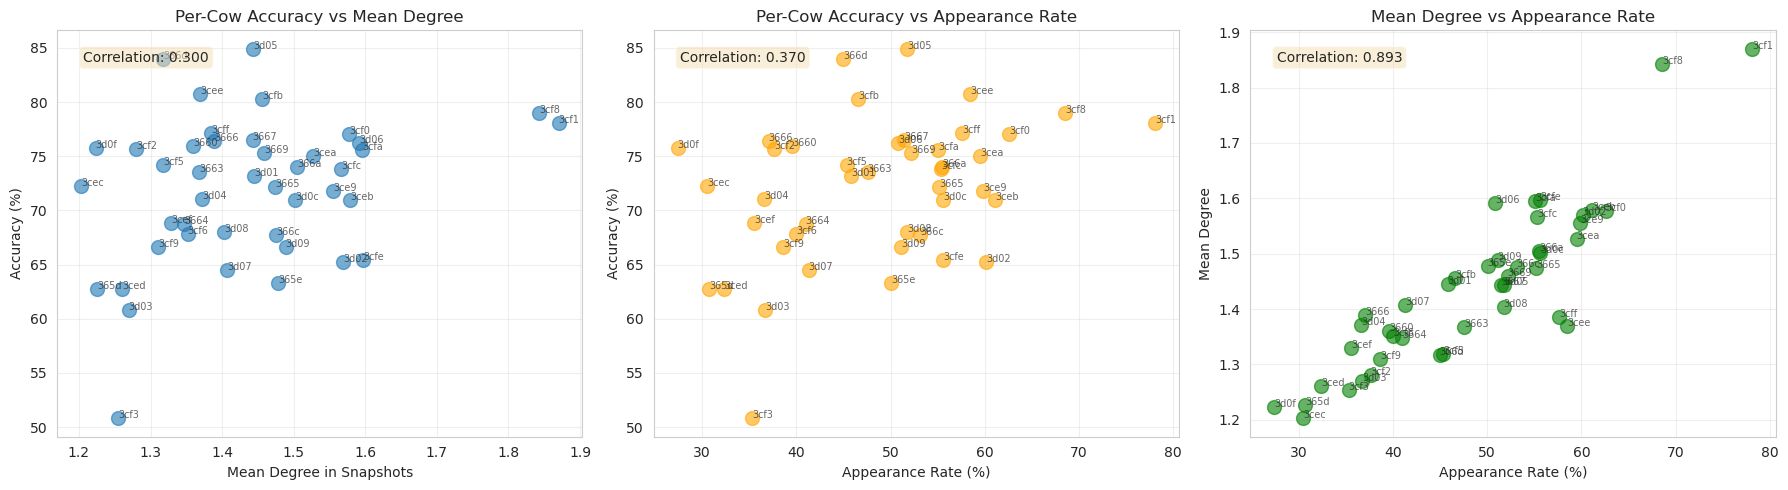

In [68]:
# Plot accuracy vs mean degree
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy vs Mean Degree
axes[0].scatter(analysis_df['mean_degree'], analysis_df['accuracy'] * 100, 
                alpha=0.6, s=100)
for _, row in analysis_df.iterrows():
    axes[0].annotate(row['cow_id'], (row['mean_degree'], row['accuracy'] * 100), 
                     fontsize=7, alpha=0.7)
axes[0].set_xlabel('Mean Degree in Snapshots')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Per-Cow Accuracy vs Mean Degree')
axes[0].grid(True, alpha=0.3)

# Add correlation
corr = analysis_df['mean_degree'].corr(analysis_df['accuracy'])
axes[0].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Accuracy vs Appearance Rate
axes[1].scatter(analysis_df['appearance_rate'] * 100, analysis_df['accuracy'] * 100, 
                alpha=0.6, s=100, color='orange')
for _, row in analysis_df.iterrows():
    axes[1].annotate(row['cow_id'], (row['appearance_rate'] * 100, row['accuracy'] * 100), 
                     fontsize=7, alpha=0.7)
axes[1].set_xlabel('Appearance Rate (%)')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Per-Cow Accuracy vs Appearance Rate')
axes[1].grid(True, alpha=0.3)

corr2 = analysis_df['appearance_rate'].corr(analysis_df['accuracy'])
axes[1].text(0.05, 0.95, f'Correlation: {corr2:.3f}', 
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Degree vs Appearance Rate
axes[2].scatter(analysis_df['appearance_rate'] * 100, analysis_df['mean_degree'], 
                alpha=0.6, s=100, color='green')
for _, row in analysis_df.iterrows():
    axes[2].annotate(row['cow_id'], (row['appearance_rate'] * 100, row['mean_degree']), 
                     fontsize=7, alpha=0.7)
axes[2].set_xlabel('Appearance Rate (%)')
axes[2].set_ylabel('Mean Degree')
axes[2].set_title('Mean Degree vs Appearance Rate')
axes[2].grid(True, alpha=0.3)

corr3 = analysis_df['appearance_rate'].corr(analysis_df['mean_degree'])
axes[2].text(0.05, 0.95, f'Correlation: {corr3:.3f}', 
             transform=axes[2].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 7. Embedding Similarity vs Network Proximity

In [69]:
# For each cow pair, compute:
# 1. Embedding similarity (cosine)
# 2. Network co-occurrence frequency (how often they appear as neighbors)

pairs_data = []
cow_id_to_idx = {cow_id: i for i, cow_id in enumerate(cow_ids)}

for i, cow1 in enumerate(cow_ids):
    for j, cow2 in enumerate(cow_ids):
        if i >= j:
            continue
        
        # Embedding similarity
        emb_sim = similarity_matrix[i, j]
        
        # Network co-occurrence
        co_occurrence = edge_counts[cow1][cow2]
        
        # Compute support: how often they appear together when both are present
        cow1_appears = cow_appearances[cow1] if cow1 in cow_appearances else 0
        cow2_appears = cow_appearances[cow2] if cow2 in cow_appearances else 0
        min_appears = min(cow1_appears, cow2_appears)
        
        support = (co_occurrence / min_appears * 100) if min_appears > 0 else 0
        
        pairs_data.append({
            'cow1': cow1,
            'cow2': cow2,
            'embedding_similarity': emb_sim,
            'co_occurrence': co_occurrence,
            'support_percent': support
        })

pairs_df = pd.DataFrame(pairs_data)
print(f"Analyzed {len(pairs_df)} cow pairs")
print(f"\nPairs with non-zero co-occurrence: {(pairs_df['co_occurrence'] > 0).sum()}")
pairs_df.head(10)

Analyzed 903 cow pairs

Pairs with non-zero co-occurrence: 902


,cow1,cow2,embedding_similarity,co_occurrence,support_percent
0,365d,365e,-0.054475,156,2.714932
1,365d,3660,0.137543,48,0.835364
2,365d,3663,0.326401,33,0.574313
3,365d,3664,-0.032325,26,0.452489
4,365d,3665,0.299813,481,8.371041
5,365d,3666,0.195538,31,0.539506
6,365d,3667,0.181886,209,3.637313
7,365d,3669,-0.304777,18,0.313261
8,365d,366a,-0.232202,174,3.028194
9,365d,366c,0.125960,128,2.227637


In [70]:
# Find pairs with high embedding similarity
top_k_similar = 20
most_similar_pairs = pairs_df.nlargest(top_k_similar, 'embedding_similarity')

print(f"Top {top_k_similar} most similar pairs in embedding space:")
print(most_similar_pairs[['cow1', 'cow2', 'embedding_similarity', 'co_occurrence', 'support_percent']])

# What percentage of these are actually linked in the network?
linked_count = (most_similar_pairs['co_occurrence'] > 0).sum()
print(f"\n{linked_count}/{top_k_similar} ({linked_count/top_k_similar*100:.1f}%) of most similar pairs are linked in network")
print(f"Mean support for top similar pairs: {most_similar_pairs['support_percent'].mean():.2f}%")

Top 20 most similar pairs in embedding space:
     cow1  cow2  embedding_similarity  co_occurrence  support_percent
464  3ce9  3d08              0.398930            222         2.292441
557  3ced  3cf3              0.381800             80         1.321004
123  3663  3664              0.365619            159         2.073552
34   365d  3d04              0.356355             71         1.235642
531  3cec  3cf3              0.351589             41         0.718416
47   365e  3667              0.345053            319         3.406300
803  3cfb  3d03              0.344159            106         1.542940
692  3cf2  3d0f              0.342537             65         1.268293
849  3d01  3d03              0.342201            222         3.231441
2    365d  3663              0.326401             33         0.574313
79   365e  3d08              0.322545            238         2.541377
15   365d  3ced              0.322541             31         0.539506
130  3663  366d              0.320289       

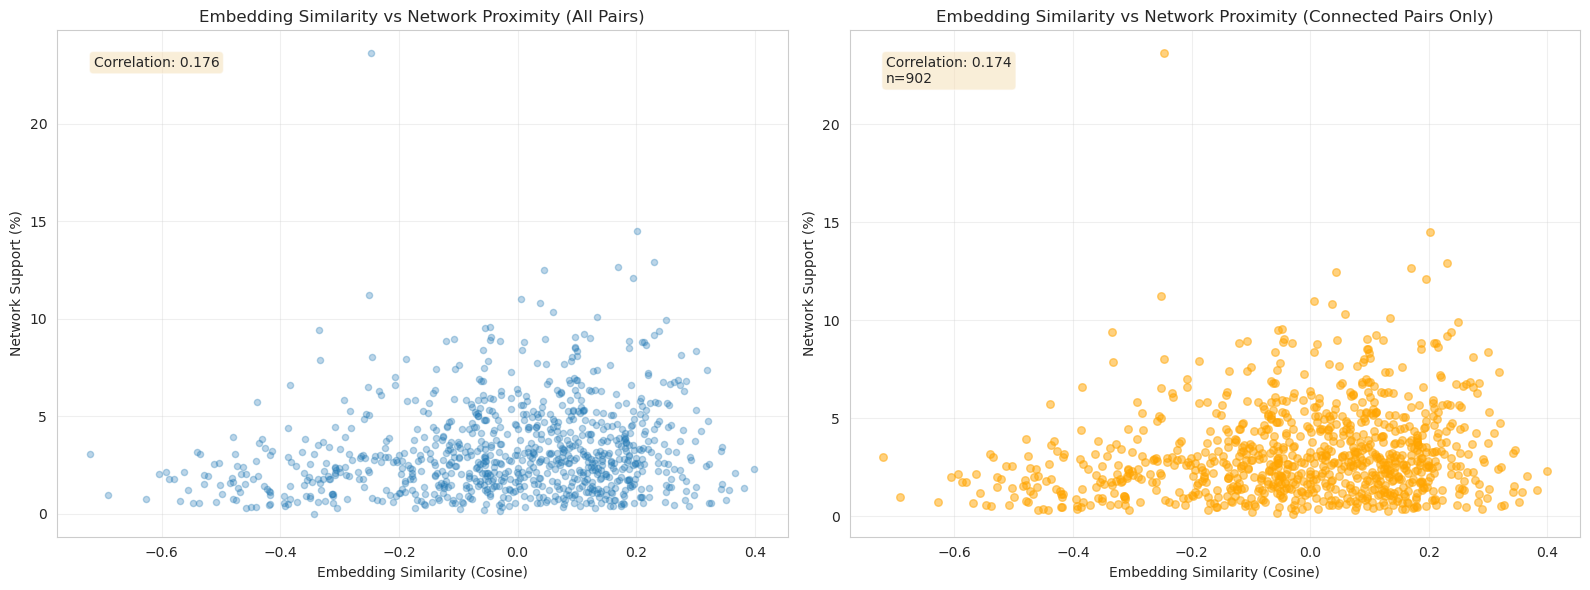

In [71]:
# Scatter plot: embedding similarity vs network support
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All pairs
axes[0].scatter(pairs_df['embedding_similarity'], pairs_df['support_percent'], 
                alpha=0.3, s=20)
axes[0].set_xlabel('Embedding Similarity (Cosine)')
axes[0].set_ylabel('Network Support (%)')
axes[0].set_title('Embedding Similarity vs Network Proximity (All Pairs)')
axes[0].grid(True, alpha=0.3)

# Add correlation
corr_all = pairs_df['embedding_similarity'].corr(pairs_df['support_percent'])
axes[0].text(0.05, 0.95, f'Correlation: {corr_all:.3f}', 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Only pairs with network connections
connected_pairs = pairs_df[pairs_df['co_occurrence'] > 0]
axes[1].scatter(connected_pairs['embedding_similarity'], connected_pairs['support_percent'], 
                alpha=0.5, s=30, color='orange')
axes[1].set_xlabel('Embedding Similarity (Cosine)')
axes[1].set_ylabel('Network Support (%)')
axes[1].set_title('Embedding Similarity vs Network Proximity (Connected Pairs Only)')
axes[1].grid(True, alpha=0.3)

corr_conn = connected_pairs['embedding_similarity'].corr(connected_pairs['support_percent'])
axes[1].text(0.05, 0.95, f'Correlation: {corr_conn:.3f}\nn={len(connected_pairs)}', 
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


Support statistics by embedding similarity quartile:
                     Mean Support %  Median Support %  Std Support %  \
similarity_quartile                                                    
Q1 (Low)                       2.59              2.11           2.29   
Q2                             3.32              2.87           2.19   
Q3                             3.61              3.12           2.28   
Q4 (High)                      3.45              2.87           2.50   

                     Connection Rate %  
similarity_quartile                     
Q1 (Low)                         99.56  
Q2                              100.00  
Q3                              100.00  
Q4 (High)                       100.00  


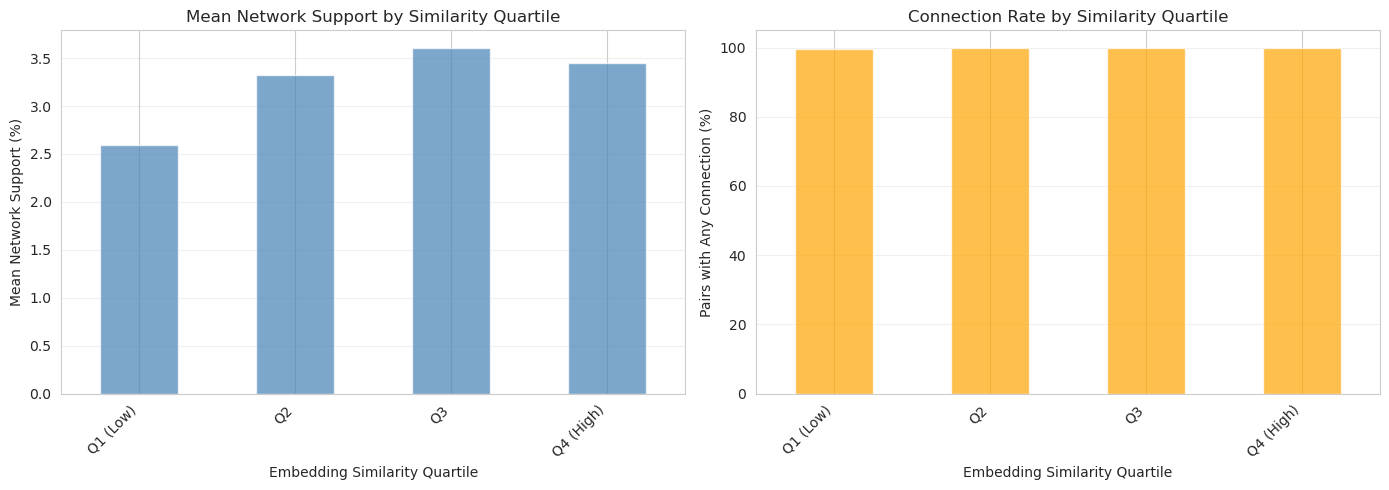

In [72]:
# Binned analysis: group by similarity quartiles
pairs_df['similarity_quartile'] = pd.qcut(pairs_df['embedding_similarity'], q=4, 
                                           labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])

quartile_stats = pairs_df.groupby('similarity_quartile').agg({
    'support_percent': ['mean', 'median', 'std'],
    'co_occurrence': lambda x: (x > 0).sum() / len(x) * 100  # % with any connection
}).round(2)

quartile_stats.columns = ['Mean Support %', 'Median Support %', 'Std Support %', 'Connection Rate %']
print("\nSupport statistics by embedding similarity quartile:")
print(quartile_stats)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

quartile_stats['Mean Support %'].plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Embedding Similarity Quartile')
axes[0].set_ylabel('Mean Network Support (%)')
axes[0].set_title('Mean Network Support by Similarity Quartile')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

quartile_stats['Connection Rate %'].plot(kind='bar', ax=axes[1], color='orange', alpha=0.7)
axes[1].set_xlabel('Embedding Similarity Quartile')
axes[1].set_ylabel('Pairs with Any Connection (%)')
axes[1].set_title('Connection Rate by Similarity Quartile')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Cluster Characterization

Cluster Characterization:
         Size  Mean Acc  Std Acc  Mean Degree  Std Degree  Mean Appear Rate  \
cluster                                                                       
0           8    0.7006   0.0638       1.4871      0.1934            0.5171   
1           9    0.7212   0.0621       1.3931      0.1415            0.4573   
2          12    0.6884   0.0704       1.4276      0.1258            0.4770   
3          14    0.7540   0.0548       1.4439      0.1428            0.4877   

         Std Appear Rate  
cluster                   
0                 0.1369  
1                 0.1335  
2                 0.0873  
3                 0.1054  


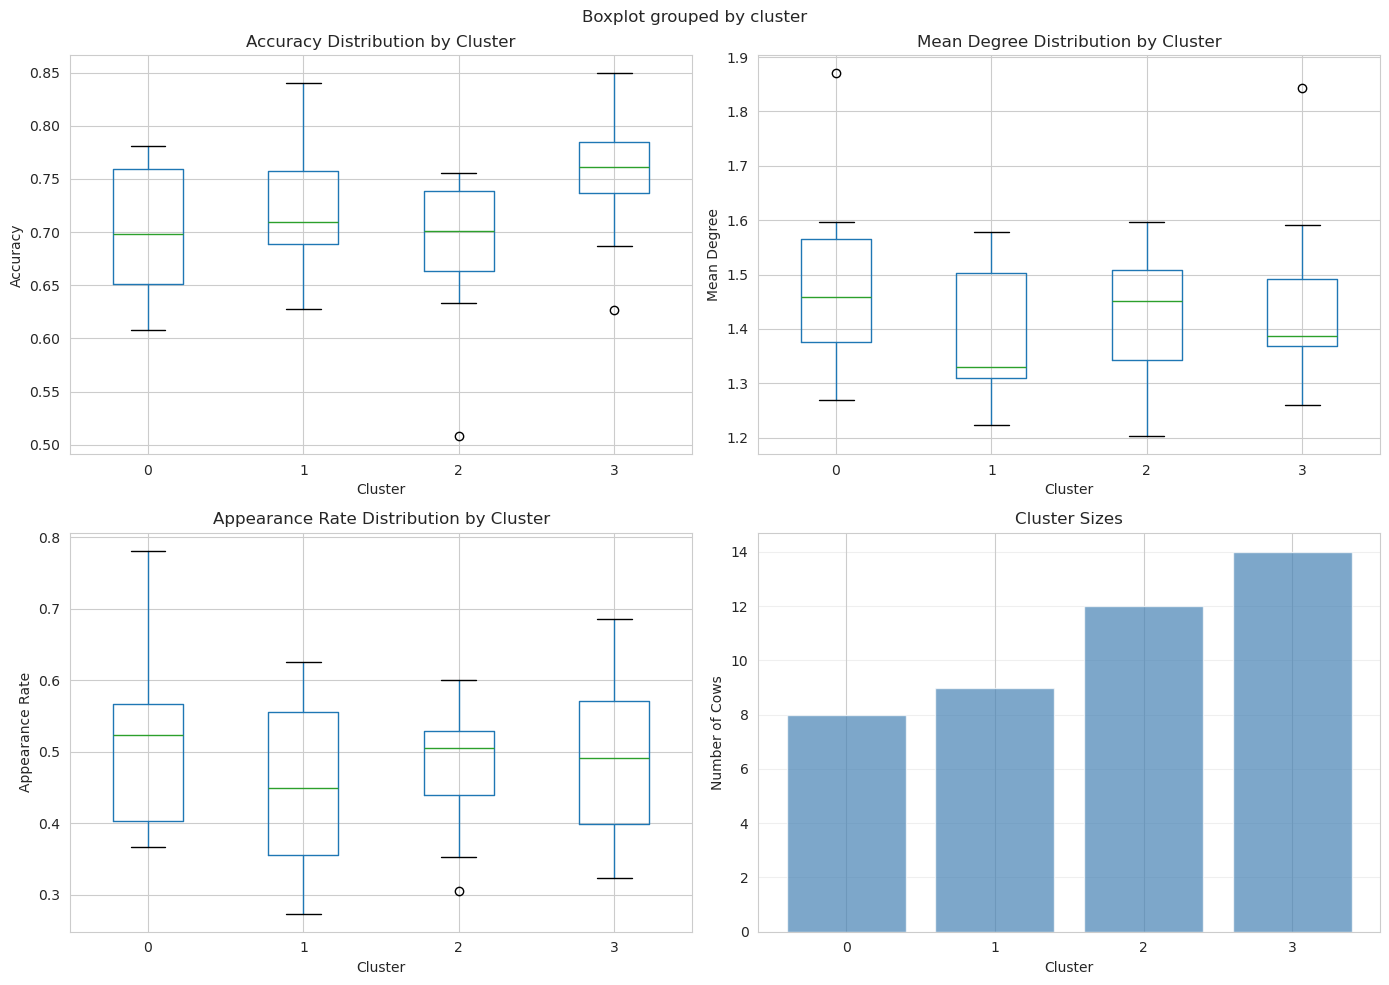

In [73]:
# Add cluster labels to analysis dataframe
analysis_df['cluster'] = cluster_labels

# Characterize each cluster
cluster_summary = analysis_df.groupby('cluster').agg({
    'cow_id': 'count',
    'accuracy': ['mean', 'std'],
    'mean_degree': ['mean', 'std'],
    'appearance_rate': ['mean', 'std']
}).round(4)

cluster_summary.columns = ['Size', 'Mean Acc', 'Std Acc', 'Mean Degree', 'Std Degree', 
                            'Mean Appear Rate', 'Std Appear Rate']
print("Cluster Characterization:")
print(cluster_summary)

# Plot cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

cluster_ids = sorted(analysis_df['cluster'].unique())

# Accuracy by cluster
analysis_df.boxplot(column='accuracy', by='cluster', ax=axes[0, 0])
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy Distribution by Cluster')
plt.sca(axes[0, 0])
plt.xticks(range(1, len(cluster_ids) + 1), cluster_ids)

# Mean degree by cluster
analysis_df.boxplot(column='mean_degree', by='cluster', ax=axes[0, 1])
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Mean Degree')
axes[0, 1].set_title('Mean Degree Distribution by Cluster')
plt.sca(axes[0, 1])
plt.xticks(range(1, len(cluster_ids) + 1), cluster_ids)

# Appearance rate by cluster
analysis_df.boxplot(column='appearance_rate', by='cluster', ax=axes[1, 0])
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Appearance Rate')
axes[1, 0].set_title('Appearance Rate Distribution by Cluster')
plt.sca(axes[1, 0])
plt.xticks(range(1, len(cluster_ids) + 1), cluster_ids)

# Cluster size
cluster_counts = analysis_df['cluster'].value_counts().sort_index()
axes[1, 1].bar(cluster_counts.index, cluster_counts.values, color='steelblue', alpha=0.7)
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Number of Cows')
axes[1, 1].set_title('Cluster Sizes')
axes[1, 1].set_xticks(cluster_ids)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [74]:
# Print cows in each cluster
for cluster_id in sorted(analysis_df['cluster'].unique()):
    cluster_cows = analysis_df[analysis_df['cluster'] == cluster_id]['cow_id'].tolist()
    print(f"\nCluster {cluster_id} ({len(cluster_cows)} cows):")
    print(', '.join(cluster_cows))


Cluster 0 (8 cows):
3cf1, 3667, 3cf2, 3ce9, 366c, 3cfe, 3d07, 3d03

Cluster 1 (9 cows):
366d, 3cf0, 3d0f, 3665, 3d0c, 3ceb, 3cef, 3cf9, 365d

Cluster 2 (12 cows):
3cfa, 3669, 3cf5, 3cfc, 3d01, 3cec, 3d08, 3cf6, 3d09, 3d02, 365e, 3cf3

Cluster 3 (14 cows):
3d05, 3cee, 3cfb, 3cf8, 3cff, 3666, 3d06, 3660, 3cea, 366a, 3663, 3d04, 3664, 3ced


## 9. Summary & Insights

In [75]:
print("="*70)
print("COWLSTM EMBEDDINGS ANALYSIS SUMMARY")
print("="*70)

print(f"\n1. MODEL PERFORMANCE:")
print(f"   - Best validation accuracy: {metadata['best_val_acc']*100:.2f}%")
print(f"   - Embedding dimension: {metadata['embedding_dim']}")
print(f"   - Number of cows: {len(cow_ids)}")

print(f"\n2. EMBEDDING CHARACTERISTICS:")
print(f"   - Mean pairwise similarity: {similarity_matrix.mean():.4f}")
print(f"   - PCA 2D variance explained: {pca.explained_variance_ratio_.sum():.2%}")
print(f"   - Optimal clusters (silhouette): {optimal_k}")
print(f"   - Silhouette score: {silhouette_score(embeddings, cluster_labels):.4f}")

print(f"\n3. ACCURACY ANALYSIS:")
print(f"   - Mean accuracy: {analysis_df['accuracy'].mean()*100:.2f}%")
print(f"   - Accuracy range: {analysis_df['accuracy'].min()*100:.2f}% - {analysis_df['accuracy'].max()*100:.2f}%")
print(f"   - Correlation with mean degree: {analysis_df['mean_degree'].corr(analysis_df['accuracy']):.3f}")
print(f"   - Correlation with appearance rate: {analysis_df['appearance_rate'].corr(analysis_df['accuracy']):.3f}")

print(f"\n4. EMBEDDING-NETWORK ALIGNMENT:")
print(f"   - Total cow pairs: {len(pairs_df)}")
print(f"   - Pairs with network connection: {(pairs_df['co_occurrence'] > 0).sum()}")
print(f"   - Correlation (similarity vs support): {pairs_df['embedding_similarity'].corr(pairs_df['support_percent']):.3f}")
print(f"   - Top {top_k_similar} similar pairs linked: {linked_count}/{top_k_similar} ({linked_count/top_k_similar*100:.1f}%)")
print(f"   - Mean support for similar pairs: {most_similar_pairs['support_percent'].mean():.2f}%")

print(f"\n5. NETWORK STATISTICS:")
print(f"   - Mean degree across cows: {network_df['mean_degree'].mean():.2f}")
print(f"   - Mean appearance rate: {network_df['appearance_rate'].mean()*100:.2f}%")
print(f"   - Correlation (degree vs appear): {network_df['mean_degree'].corr(network_df['appearance_rate']):.3f}")

print("\n" + "="*70)

COWLSTM EMBEDDINGS ANALYSIS SUMMARY

1. MODEL PERFORMANCE:
   - Best validation accuracy: 73.63%
   - Embedding dimension: 16
   - Number of cows: 43

2. EMBEDDING CHARACTERISTICS:
   - Mean pairwise similarity: -0.0178
   - PCA 2D variance explained: 15.80%
   - Optimal clusters (silhouette): 4
   - Silhouette score: 0.0414

3. ACCURACY ANALYSIS:
   - Mean accuracy: 71.89%
   - Accuracy range: 50.82% - 84.91%
   - Correlation with mean degree: 0.300
   - Correlation with appearance rate: 0.370

4. EMBEDDING-NETWORK ALIGNMENT:
   - Total cow pairs: 903
   - Pairs with network connection: 902
   - Correlation (similarity vs support): 0.176
   - Top 20 similar pairs linked: 20/20 (100.0%)
   - Mean support for similar pairs: 2.92%

5. NETWORK STATISTICS:
   - Mean degree across cows: 1.44
   - Mean appearance rate: 48.39%
   - Correlation (degree vs appear): 0.893

